In [1]:
!pip install pyro-ppl

     |████████████████████████████████| 614kB 2.9MB/s 


In [1]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import pdb
import gc
from sklearn.metrics import mean_squared_error
import torchvision
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from torch.autograd import Variable
from torch.nn.parameter import Parameter
from torchvision.datasets import MNIST, CIFAR10
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
from pyro.nn import AutoRegressiveNN
from torchvision.utils import make_grid
%matplotlib inline

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Consider HVAE. Denote by $\theta$ all the parameters of interest simultaneously for convenience. I will omit dependence on $\theta$ notationaly. Let us compute the objective:

$$
\mathcal{L}(\theta,x) = \mathbb{E}_{z_K,\rho_K}[\log \frac{p(x,z_K,\rho_K)}{q_K(z_K,\rho_K)}] = \mathbb{E}_{z_K,\rho_K}[\log \frac{p(x|z_K) \mathcal{N}(z_K|0,I) \mathcal{N}(\rho_K|0,I)}{q_K(z_K,\rho_K)}],
$$
where $p(x|z_K)$ is completely defined by decoder. We can compute $q_K(z_K,\rho_K)$ from change of variables formula for $z_K (z_0,\rho_0),\rho_K (z_0,\rho_0) = H(z_0,\rho_0)$:

$$
q_K( z_K (z_0,\rho_0),\rho_K (z_0,\rho_0)) |\det \nabla H (z_0,\rho_0)| = q_0 (z_0,\rho_0),
$$
thus:
$$
q_K( z_K (z_0,\rho_0),\rho_K (z_0,\rho_0) ) = q_0 (z_0,\rho_0) |\det \nabla H (z_0,\rho_0)|^{-1} = q_0 (z_0) \mathcal{N}(\rho_0|0,\beta_0^{-1}I) |\det \nabla H (z_0,\rho_0)|^{-1}.
$$
For HVAE:
$$
|\det \nabla H (z_0,\rho_0)| = \beta_0^{\frac{l}{2}}, 
$$
$$
q_K( z_K (z_0,\rho_0),\rho_K (z_0,\rho_0) ) = q_0 (z_0) \mathcal{N}(\rho_0|0,\beta_0^{-1}I) \beta_0^{-\frac{l}{2}}
$$

with $l= \dim (z_0)$.
Next, $z_0 = \mu(x) + \sigma(x) \epsilon, \epsilon \sim \mathcal{N}(\epsilon |0,I)$ and:
$$
q_0 (z_0(\epsilon)) \prod_j \sigma(x)_j = p(\epsilon) = \mathcal{N}(\epsilon |0,I), q_0 (z_0(\epsilon)) = (\prod_j \sigma(x)_j)^{-1}\mathcal{N}(\epsilon |0,I)
$$
Finally: 
$$
\rho_0 = \beta_0^{-\frac{1}{2}} \gamma_0, p(\gamma_0) = \mathcal{N}(\gamma_0|0,I), p(\rho_0(\gamma_0)) = \beta_0^{\frac{l}{2}} \mathcal{N}(\gamma_0|0,I).
$$


Due to Law of the Unconscious Statistician https://en.wikipedia.org/wiki/Law_of_the_unconscious_statistician: 
$$
\mathbb{E}_{z_K,\rho_K}[\log \frac{p(x|z_K) \mathcal{N}(z_K|0,I) \mathcal{N}(\rho_K|0,I)}{q_K(z_K,\rho_K)}] = \mathbb{E}_{\epsilon,\gamma_0} [\log \frac{p(x|z_K(z_0(\epsilon))) \mathcal{N}(z_K(z_0(\epsilon))|0,I)\mathcal{N}(\rho_K(\rho_0(\gamma_0))|0,I)}{(\prod_j \sigma(x)_j)^{-1}\mathcal{N}(\epsilon |0,I) \beta_0^{\frac{l}{2}} \mathcal{N}(\gamma_0|0,I) \beta_0^{-\frac{l}{2}} }] \propto^+ 
\mathbb{E}_{\epsilon,\gamma_0}[\log p(x|z_K(z_0(\epsilon))) - 1/2||z_K(z_0(\epsilon))||_2^2 - 1/2||\rho_K(\rho_0(\gamma_0))||_2^2] + \sum_{j} \log (\sigma(x)_j)]
$$




Finally:
$$
\mathcal{L}(\theta,x) \propto^+ \mathbb{E}_{\epsilon,\gamma_0}[\log p(x|z_K(z_0(\epsilon))) - 1/2||z_K(z_0(\epsilon))||_2^2 - 1/2||\rho_K(\rho_0(\gamma_0))||_2^2] + \sum_{j} \log (\sigma(x)_j)],
$$
and:
$$
\nabla_{\theta} [\log p(x|z_K(z_0(\epsilon))) - 1/2||z_K(z_0(\epsilon))||_2^2 - 1/2||\rho_K(\rho_0(\gamma_0))||_2^2 + \sum_{j} \log (\sigma(x)_j)],
$$
is unbiased estimate of $\nabla_{\theta} \mathcal{L}(\theta,x)$.


$\textbf{Now assume, we additionallly apply some flow to}$ $(z_K,\rho_K)$:

$$
(\tilde{z},\tilde{\rho})=F(z_K,\rho_K),
$$
$$
q(\tilde{z},\tilde{\rho}) = q_K(z_K,\rho_K) |\det \nabla F(z_K,\rho_K)|^{-1},
$$
then:
$$
\mathcal{L}(\theta,x) \propto^+ \mathbb{E}_{\epsilon,\gamma_0}[\log p(x|\tilde{z}) - 1/2||\tilde{z}||_2^2 - 1/2||\tilde{\rho}||_2^2 + \log |\det \nabla F(z_K,\rho_K)|] + \sum_{j} \log (\sigma(x)_j),
$$
and:
$$
\nabla_{\theta}[\log p(x|\tilde{z}) - 1/2||\tilde{z}||_2^2 - 1/2||\tilde{\rho}||_2^2 + \log |\det \nabla F(z_K,\rho_K)| + \sum_{j} \log (\sigma(x)_j)] 
$$
is still an unbiased estimate of $\nabla_{\theta} \mathcal{L}(\theta,x)$.

In [3]:
class IATransform(nn.Module):
    def __init__(self, in_dim, h_dim, rand_perm=True):
        super(IATransform, self).__init__()
        self.AR = AutoRegressiveNN(in_dim,[h_dim])
        self.rand_perm=rand_perm
    def forward(self, x):
        """
        Return transformed sample and log determinant
        """
        mu, logsigma = self.AR(x)
        res = mu+logsigma.exp()*x
        res = res[torch.randperm(res.shape[0])] if self.rand_perm else res
        return res,logsigma.sum(axis=1)


class IAF(nn.Module):
    def __init__(self, in_dim, h_dim, depth):
        super(IAF, self).__init__()
        """
        in_dim - inout dimention
        h_dim - hidden dimention of the autoregressive NN
        depth - number of IA transformations
        """
        self.Trans = nn.ModuleList([IATransform(in_dim,h_dim) for i in range(depth)])
        

    def forward(self, x):
        """
        Return transformed sample and log determinant
        """
        logdet = 0
        for t in self.Trans:
          x,d = t(x)
          logdet+=d
        return x,logdet

In [4]:
class Reshape(nn.Module):
    def __init__(self, *shape):
        super().__init__()
        self.shape = shape
        
    def forward(self, x):
        return x.reshape(*self.shape)

In [5]:
class HVAE(nn.Module):
  def __init__(self,z_dim = 64,K=15,max_eps=0.5,Flow = None):
    super().__init__()
    self.z_dim = z_dim
    self.K = K
    self.Flow = Flow
    self.max_eps = max_eps
    self.err = 1e-10
    self.encoder = nn.Sequential(
            
                nn.BatchNorm2d(1),
                nn.Conv2d(1, 16, 5, 2, 2), # 28 -> 14 
                nn.Softplus(),
                nn.BatchNorm2d(16),
            
                nn.Conv2d(16, 32, 5, 2, 2), # 14 -> 7
                nn.Softplus(),
            
                nn.BatchNorm2d(32),
                nn.Conv2d(32, 32, 5, 2, 2), # 7 -> 4
            
                nn.BatchNorm2d(32),
                nn.Flatten(),
                nn.Linear(32*4*4, 450),
                nn.Softplus(),
                nn.BatchNorm1d(450),
                nn.Linear(450, 2*z_dim)
            )
    
    self.decoder = nn.Sequential(
                nn.BatchNorm1d(z_dim),
                nn.Linear(z_dim, 450),
                nn.Softplus(),
                nn.BatchNorm1d(450),
                nn.Linear(450, 32*4*4),
                nn.Softplus(),
                Reshape(-1, 32, 4, 4),
            
                nn.BatchNorm2d(32),
                nn.Conv2d(32, 32, 5, 1, 2), 
                nn.UpsamplingNearest2d(size=7), # 4 -> 7
                nn.Softplus(),
            
                nn.BatchNorm2d(32),
                nn.Conv2d(32, 16, 5, 1, 2),
                nn.UpsamplingNearest2d(size=14), # 7 -> 14
                nn.Softplus(),
            
                nn.BatchNorm2d(16),
                nn.Conv2d(16, 16, 5, 1, 2),
                nn.UpsamplingNearest2d(size=28), # 14 -> 28
                nn.Softplus(),

                nn.Conv2d(16, 1, 5, 1, 2),
                nn.Sigmoid()
            )
    
    self.logit_eps = Parameter(torch.zeros(z_dim),requires_grad = True)
    self.log_alphas = Parameter(torch.zeros(K),requires_grad = True)

  def HIS(self,x):
    bs = x.shape[0]
    eps = self.max_eps*F.sigmoid(self.logit_eps)
    alphas = self.log_alphas.exp()
    beta_sqrt = alphas.prod()
    out = self.encoder(x)
    q_mu, q_sigma = out[:,:self.z_dim],out[:,self.z_dim:]
    q_sigma = F.softplus(q_sigma)
    z = q_mu+q_sigma*torch.randn_like(q_mu)
    gamma = torch.randn_like(q_mu)
    rho = gamma/beta_sqrt

    self.decoder.requires_grad_(False)
    for k in range(self.K):
      rho = rho - 0.5*eps*self._get_grad_U(x,z)
      z = z + eps*rho
      rho = rho - 0.5*eps*self._get_grad_U(x,z)
      rho = rho*alphas[k]

    self.decoder.requires_grad_(True)
    res = 0.
    if self.Flow is not None:
      vec = torch.cat([z,rho],axis=1)
      vec,logdet = self.Flow(vec)
      z = vec[:,:self.z_dim]
      rho = vec[:,self.z_dim:]
      res = res - logdet.sum()/bs

    probs = self.decoder(z)
    
    res = res - (x*torch.log(probs+self.err)+(1-x)*torch.log(1-probs+self.err)).sum()/bs
    res = res + 0.5*(rho.pow(2)).sum()/bs
    res = res + 0.5*(z.pow(2)).sum()/bs
    res = res - torch.log(q_sigma).sum()/bs

    return res

  def _get_grad_U(self,x,z):
    z = z.clone().detach().requires_grad_(True)
    probs = self.decoder(z)
    log_lik = (x*torch.log(probs+self.err)+(1-x)*torch.log(1-probs+self.err)).sum()
    log_lik.sum().backward()
    return (z.grad+z).detach().requires_grad_(False)



In [6]:
transform = transforms.Compose([
    transforms.ToTensor(),
    # lambda x: x.round()
])
data = MNIST('data/mnist', download=True, transform=transform, train=False)

In [7]:
batch_size = 256
data_loader = DataLoader(data, #Subset(data, torch.arange(100)),
                         batch_size=batch_size, shuffle=True)
z_dim=64

HVAE without flows:

In [8]:
torch.manual_seed(0)
model = HVAE(z_dim=z_dim,K=20,max_eps=0.01).to(device)
opt = torch.optim.Adam(model.parameters(),lr=1e-3)

In [9]:
n_epochs=30
for epoch in range(n_epochs):
  l=[]
  for batch,_ in data_loader:
    opt.zero_grad()
    loss = model.HIS(batch.to(device))
    loss.backward()
    opt.step()
    l.append(loss.item())
  print('Epoch: {}; mean loss: {}'.format(epoch+1,np.mean(l)) )

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 1; mean loss: 291.61501998901366
Epoch: 2; mean loss: 225.91072044372558
Epoch: 3; mean loss: 214.98839797973633
Epoch: 4; mean loss: 208.6392478942871
Epoch: 5; mean loss: 204.3797924041748
Epoch: 6; mean loss: 201.05787925720216
Epoch: 7; mean loss: 197.0859130859375
Epoch: 8; mean loss: 194.01291732788087
Epoch: 9; mean loss: 190.79687118530273
Epoch: 10; mean loss: 187.42355575561524
Epoch: 11; mean loss: 186.1652374267578
Epoch: 12; mean loss: 184.05493621826173
Epoch: 13; mean loss: 181.5046813964844
Epoch: 14; mean loss: 181.26264114379882
Epoch: 15; mean loss: 180.24504547119142
Epoch: 16; mean loss: 179.0238437652588
Epoch: 17; mean loss: 178.134867477417
Epoch: 18; mean loss: 177.32181930541992
Epoch: 19; mean loss: 177.0947666168213
Epoch: 20; mean loss: 176.80702514648436
Epoch: 21; mean loss: 175.40754585266114
Epoch: 22; mean loss: 175.66290588378905
Epoch: 23; mean loss: 175.11057662963867
Epoch: 24; mean loss: 174.2638645172119
Epoch: 25; mean loss: 173.474007797

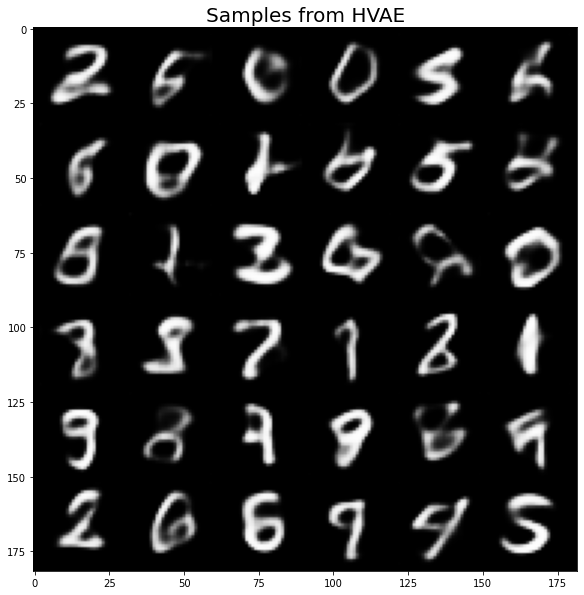

In [10]:
plt.figure(figsize=(15, 10))
n = 6
z = torch.randn(n**2, z_dim)
x_rec = model.decoder(z.to(device))
plt.imshow(make_grid(x_rec.cpu(), nrow=n).permute(1, 2, 0).detach().numpy(), cmap="Greys")
plt.title('Samples from HVAE',fontsize=20)

plt.show()

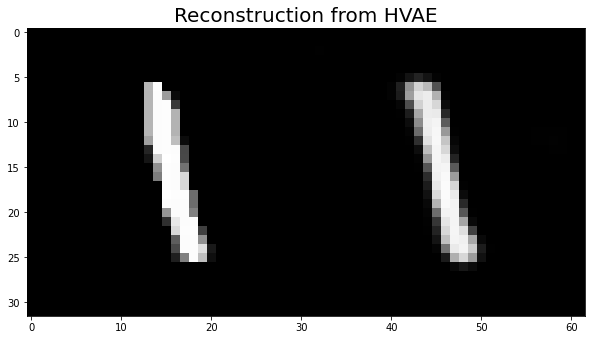

In [11]:
idx = np.random.choice(list(range(10000)),1)[0]

model.eval()

x = data[idx][0][None, ...]
out = model.encoder(x.to(device))
z = out[:,:z_dim]
x_rec = model.decoder(z)
plt.figure(figsize=(10,8))
plt.imshow(make_grid(torch.cat([x.cpu(), x_rec.cpu()])).permute(1, 2, 0).detach().numpy(), cmap="Greys")
plt.title('Reconstruction from HVAE',fontsize=20)
plt.show()

VAE with IAF:

In [12]:
torch.manual_seed(0)
model_IAF = HVAE(z_dim=z_dim,K=0,max_eps=0.01,Flow = IAF(2*z_dim,20*z_dim,5)).to(device)
opt = torch.optim.Adam(model_IAF.parameters(),lr=1e-3)

In [13]:
n_epochs=15
for epoch in range(n_epochs):
  l=[]
  for batch,_ in data_loader:
    opt.zero_grad()
    loss = model_IAF.HIS(batch.to(device))
    loss.backward()
    opt.step()
    l.append(loss.item())
  print('Epoch: {}; mean loss: {}'.format(epoch+1,np.mean(l)) )

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 1; mean loss: 326.1532577514648
Epoch: 2; mean loss: 281.40367889404297
Epoch: 3; mean loss: 277.33176574707034
Epoch: 4; mean loss: 276.08712615966795
Epoch: 5; mean loss: 275.3363998413086
Epoch: 6; mean loss: 273.9520683288574
Epoch: 7; mean loss: 273.33963165283205
Epoch: 8; mean loss: 272.88454360961913
Epoch: 9; mean loss: 272.62983016967775
Epoch: 10; mean loss: 272.4944892883301
Epoch: 11; mean loss: 272.0377250671387
Epoch: 12; mean loss: 272.07870025634764
Epoch: 13; mean loss: 271.84061126708986
Epoch: 14; mean loss: 272.42686614990237
Epoch: 15; mean loss: 271.49856033325193


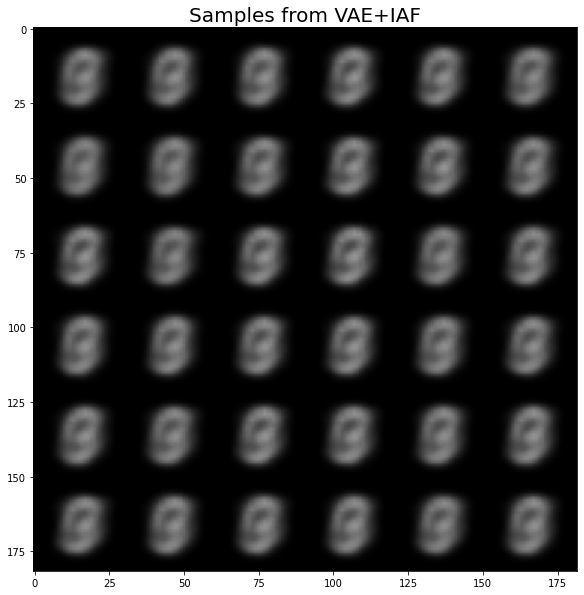

In [14]:
plt.figure(figsize=(15, 10))
n = 6
z = torch.randn(n**2, z_dim)
x_rec = model_IAF.decoder(z.to(device))
plt.imshow(make_grid(x_rec.cpu(), nrow=n).permute(1, 2, 0).detach().numpy(), cmap="Greys")
plt.title('Samples from VAE+IAF',fontsize=20)

plt.show()

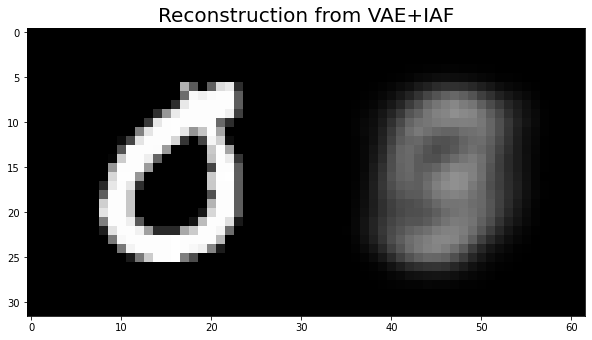

In [15]:
idx = np.random.choice(list(range(10000)),1)[0]

model_IAF.eval()

x = data[idx][0][None, ...]
out = model_IAF.encoder(x.to(device))
z = out[:,:z_dim]
x_rec = model_IAF.decoder(z)
plt.figure(figsize=(10,8))
plt.imshow(make_grid(torch.cat([x.cpu(), x_rec.cpu()])).permute(1, 2, 0).detach().numpy(), cmap="Greys")
plt.title('Reconstruction from VAE+IAF',fontsize=20)
plt.show()

HVAE with IAF:

In [20]:
torch.manual_seed(0)
model_HVAE_IAF = HVAE(z_dim=z_dim,K=20,max_eps=0.1,Flow = IAF(2*z_dim,20*z_dim,5)).to(device)
opt = torch.optim.Adam(model_HVAE_IAF.parameters(),lr=1e-4)

In [21]:
n_epochs=15
for epoch in range(n_epochs):
  l=[]
  for batch,_ in data_loader:
    opt.zero_grad()
    loss = model_HVAE_IAF.HIS(batch.to(device))
    loss.backward()
    opt.step()
    l.append(loss.item())
  print('Epoch: {}; mean loss: {}'.format(epoch+1,np.mean(l)) )

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 1; mean loss: 453.4980438232422
Epoch: 2; mean loss: 379.6600975036621
Epoch: 3; mean loss: 340.81237030029297
Epoch: 4; mean loss: 324.1618255615234
Epoch: 5; mean loss: 313.2893836975098
Epoch: 6; mean loss: 306.29679946899415
Epoch: 7; mean loss: 300.1503479003906
Epoch: 8; mean loss: 297.60580825805664
Epoch: 9; mean loss: 295.2253158569336
Epoch: 10; mean loss: 293.25775680541994
Epoch: 11; mean loss: 291.36144561767577
Epoch: 12; mean loss: 289.32334365844724
Epoch: 13; mean loss: 288.5241539001465
Epoch: 14; mean loss: 287.5567710876465
Epoch: 15; mean loss: 285.15097122192384


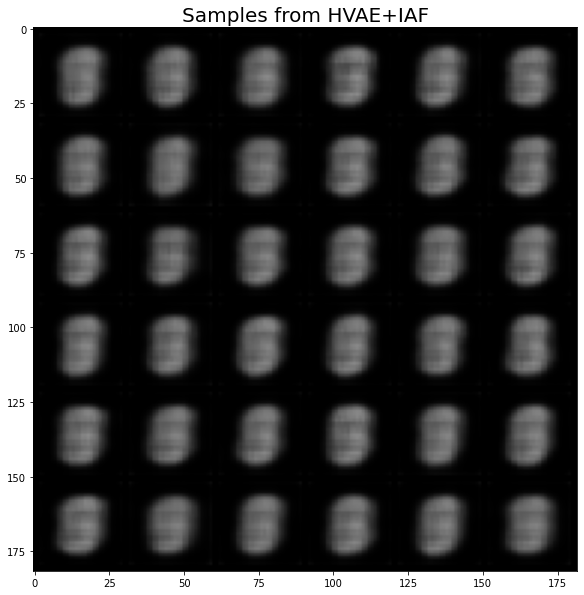

In [22]:
plt.figure(figsize=(15, 10))
n = 6
z = torch.randn(n**2, z_dim)
x_rec = model_HVAE_IAF.decoder(z.to(device))
plt.imshow(make_grid(x_rec.cpu(), nrow=n).permute(1, 2, 0).detach().numpy(), cmap="Greys")
plt.title('Samples from HVAE+IAF',fontsize=20)

plt.show()

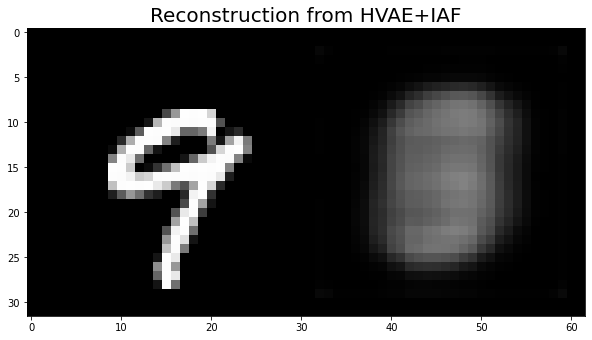

In [23]:
idx = np.random.choice(list(range(10000)),1)[0]

model_HVAE_IAF.eval()

x = data[idx][0][None, ...]
out = model_HVAE_IAF.encoder(x.to(device))
z = out[:,:z_dim]
x_rec = model_HVAE_IAF.decoder(z)
plt.figure(figsize=(10,8))
plt.imshow(make_grid(torch.cat([x.cpu(), x_rec.cpu()])).permute(1, 2, 0).detach().numpy(), cmap="Greys")
plt.title('Reconstruction from HVAE+IAF',fontsize=20)
plt.show()

We see that adding flows (IAF particulary) does not help to improve results.